# Variational autoencoder for collaborative filtering

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

Parts of this notebook are based on the paper [Variational Autoencoders for collaborativge filtering](https://arxiv.org/pdf/1802.05814.pdf) and on the notebook in [here](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/989e57faf048eb76221cad851ff224ccca02fa81/Conferences/WWW/MultiVAE_github/VAE_ML20M_WWW2018.ipynb). As in the paper we want to consider it as implicit feedback, so we want to change the rating to a 0, 1 point system. Anything we score 4 or higher will be make into a 1, anythin else will be zero. We also only consider the users that have more than five ratings and the top 100 most rated movies.

In [2]:
movielens = pd.read_csv("../data/ml-20m/ratings.csv").drop("timestamp", axis=1)

# Get the user with at least 5 ratings
relevant_users = movielens.groupby("userId", as_index=False).agg({'movieId':len})
releant_users = relevant_users[relevant_users.movieId > 4].drop('movieId', axis=1)

dataset = movielens.merge(releant_users)

# Get 100 most rated movies
top_100 = movielens.movieId.value_counts()[:100].index.values
dataset = dataset[dataset['movieId'].isin(top_100)]

# Change to implicit feedback 
dataset['rating'] = dataset['rating'].apply(lambda r: 0 if r<4 else 1)

To make our life easier we will reindex the userId and the movieId

In [3]:
idx2movie = dataset.movieId.unique()
movie2idx = {movie:idx for idx, movie in enumerate(idx2movie)}

dataset['movieId'] = dataset['movieId'].apply(lambda movie: movie2idx[movie])

idx2user = dataset.userId.unique()
user2idx = {user:idx for idx, user in enumerate(idx2user)}
dataset['userId'] = dataset['userId'].apply(lambda user: user2idx[user])

We build our model next. A conceptual graphical representation is displayed below 

![caption](../figures/MVAE.png)

In [4]:
class MultiVAE(nn.Module):
    
    def __init__(self,p_dims=[80, 40], nb_items=100, minibatch_size=100):   
        super(MultiVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(nb_items, p_dims[0]), 
            nn.Tanh(), 
            nn.Linear(p_dims[0], p_dims[1]),
            nn.Tanh(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(p_dims[1]//2, p_dims[0]),
            nn.Tanh(),
            nn.Linear(p_dims[0], nb_items),
            nn.Tanh(),
        )
        self.minibatch_size = minibatch_size
    
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.normal(torch.zeros_like(mu), torch.ones_like(mu))
        
        return mu + eps*std

    
    def forward(self, users):
        # users are bz x nb_items with only zeros and ones
        latent_rep = self.encoder(users)
        emb_size = latent_rep.size(1)//2
        mu = latent_rep[:, :emb_size] 
        logvar = latent_rep[:, emb_size:]

        z = self.reparametrize(mu, logvar) 

        logits = self.decoder(z)

        # This is the KL between q(z|x_i) and p(z). That is tries to keep 
        # the distributions within the p(z) region
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

        # This corresponds to the sampling
        reconstruction = -(torch.log_softmax(logits, dim=1)*users).sum(dim=1)

        loss = (self.minibatch_size*reconstruction + KLD).mean()
        
        return loss

    
    def reconstruct(self, users):
        self.eval()

        latent_rep = self.encoder(users)
        emb_size = latent_rep.size(1)//2
        mu = latent_rep[:, :emb_size] 
        logvar = latent_rep[:, emb_size:]

        z = self.reparametrize(mu, logvar) 

        logits = self.decoder(z)

        return torch.softmax(logits, dim=1).detach().numpy()


In [6]:
# MODEL 
m_vae = MultiVAE(minibatch_size=200)

Before training, we need the dataloader



In [7]:
data = torch.zeros(len(user2idx), 100)
movie_lists = dataset.groupby('userId', as_index=False).agg({'movieId':list})
for user_row in movie_lists.iterrows():
    data[user_row[1]['userId']][user_row[1]['movieId']] = 1
dataloader = DataLoader(data, batch_size=50, shuffle=True)

We also need an optimizer and we are ready to train

In [8]:
optim = torch.optim.Adam(m_vae.parameters())
losses = []
from tqdm import trange
for i in trange(5):
    for users in dataloader: #tqdm(dataloader, total=len(dataloader)):
        optim.zero_grad()
        loss = m_vae(users)
        loss.backward()
        optim.step()
        losses.append(loss.item())


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.56s/it]


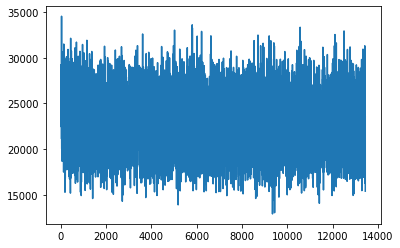

In [9]:
plt.plot(losses)
plt.show()

## Visualization and similarity for reconstructed data

We now reconstruct a subset of the data

In [10]:
# size of subset to be recunstructed
subset_size = 20

In [11]:
# recunstruction 
rec = m_vae.reconstruct(data[:subset_size])

The following shows, respectively, the original data and its reconstructed counterpart

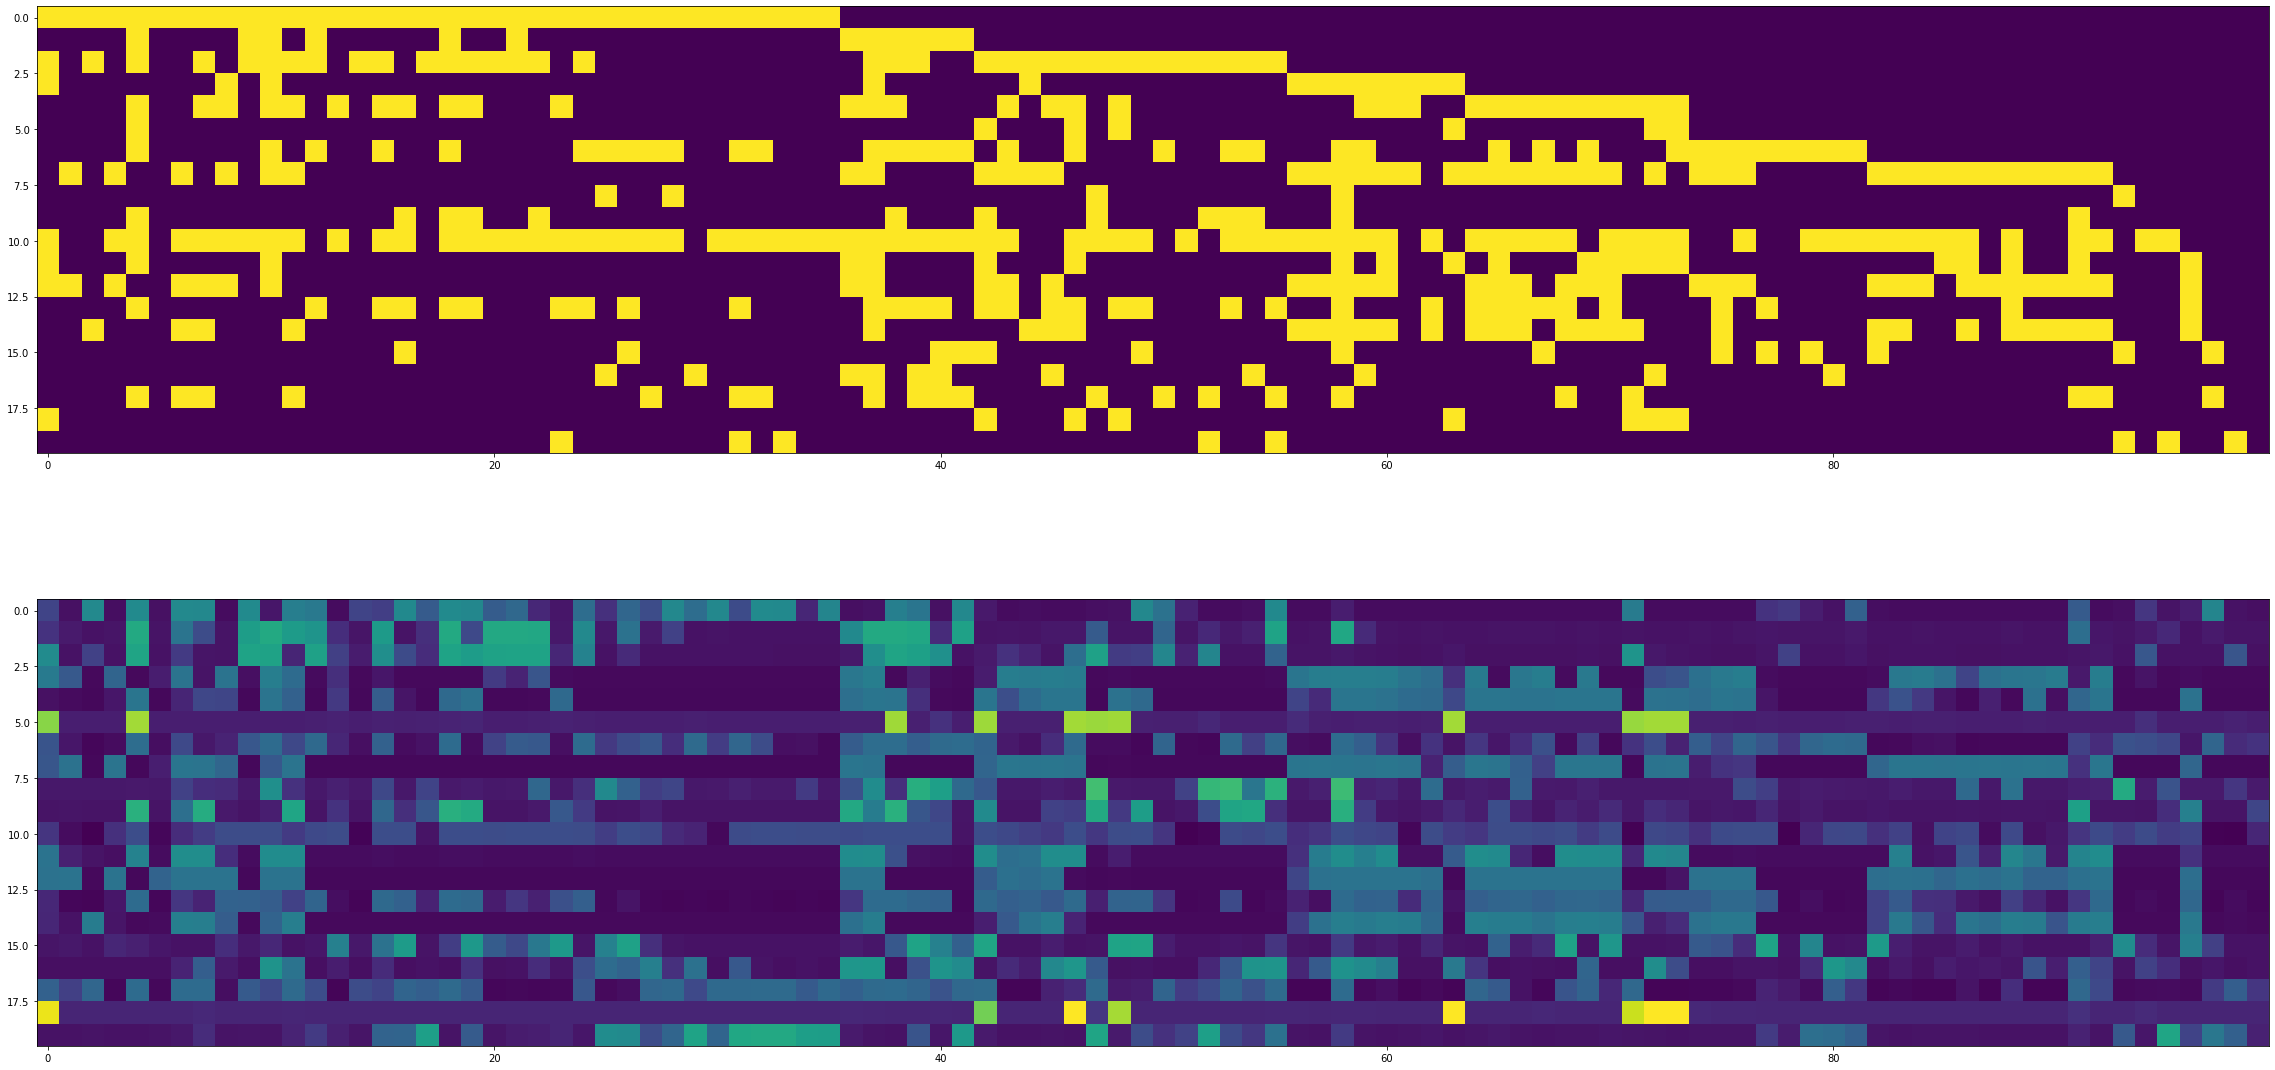

In [12]:
_, ax = plt.subplots(2, 1, figsize=(40,subset_size))
ax[0].imshow(data[:subset_size])
ax[1].imshow(rec)
plt.show()

We can also show the comparison with the binarized version of the reconstructed counterpart.

Note how the plot of the reconstructed data changes as the threshold for the binarized version is relaxed

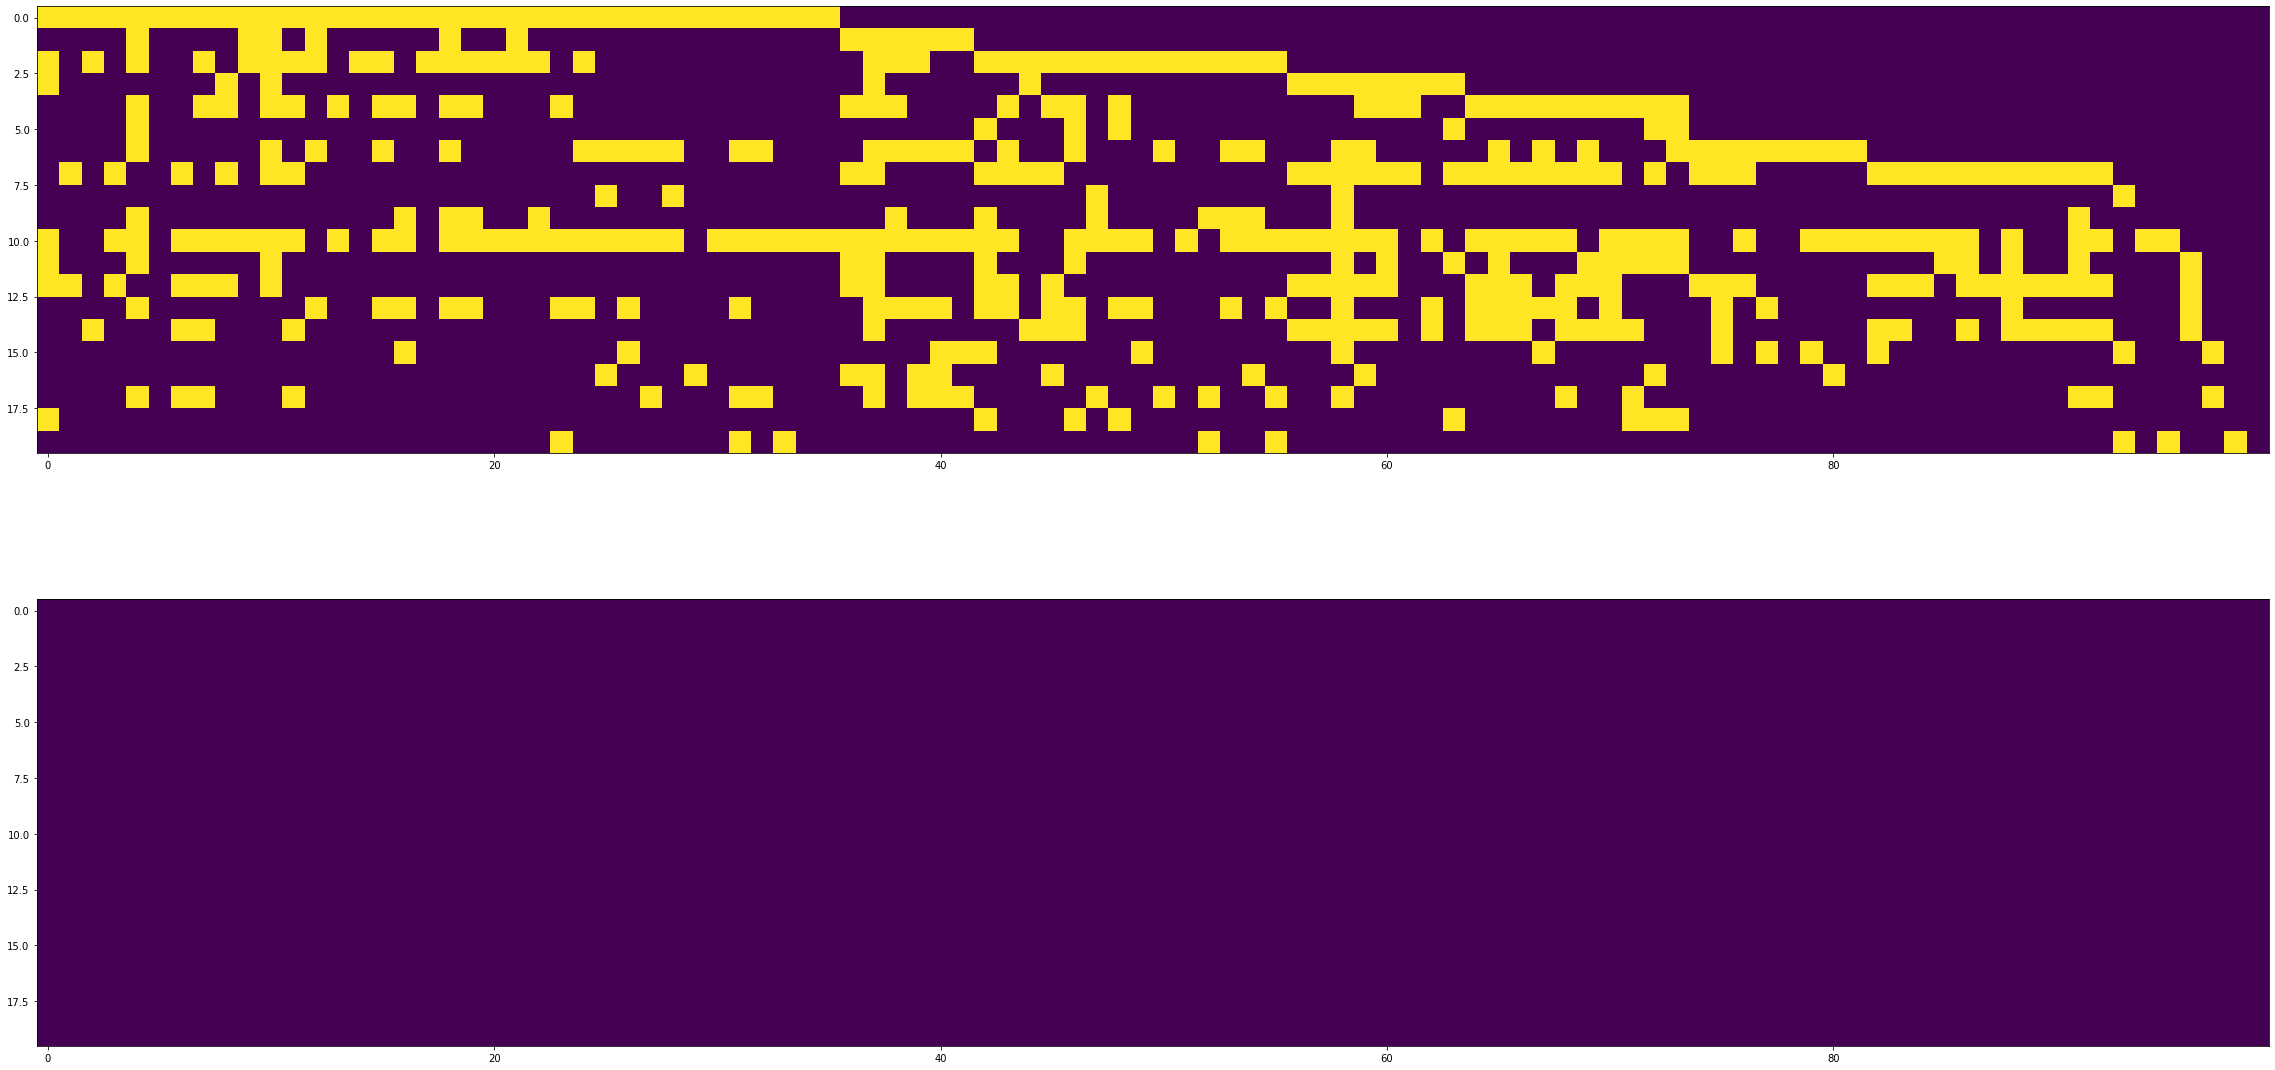

In [13]:
rec_threshold_hard = 0.5
rec_binarized_hard = np.where(rec>=rec_threshold_hard, 1, 0)
_, ax = plt.subplots(2, 1, figsize=(40,subset_size))
ax[0].imshow(data[:subset_size])
ax[1].imshow(rec_binarized_hard)
plt.show()

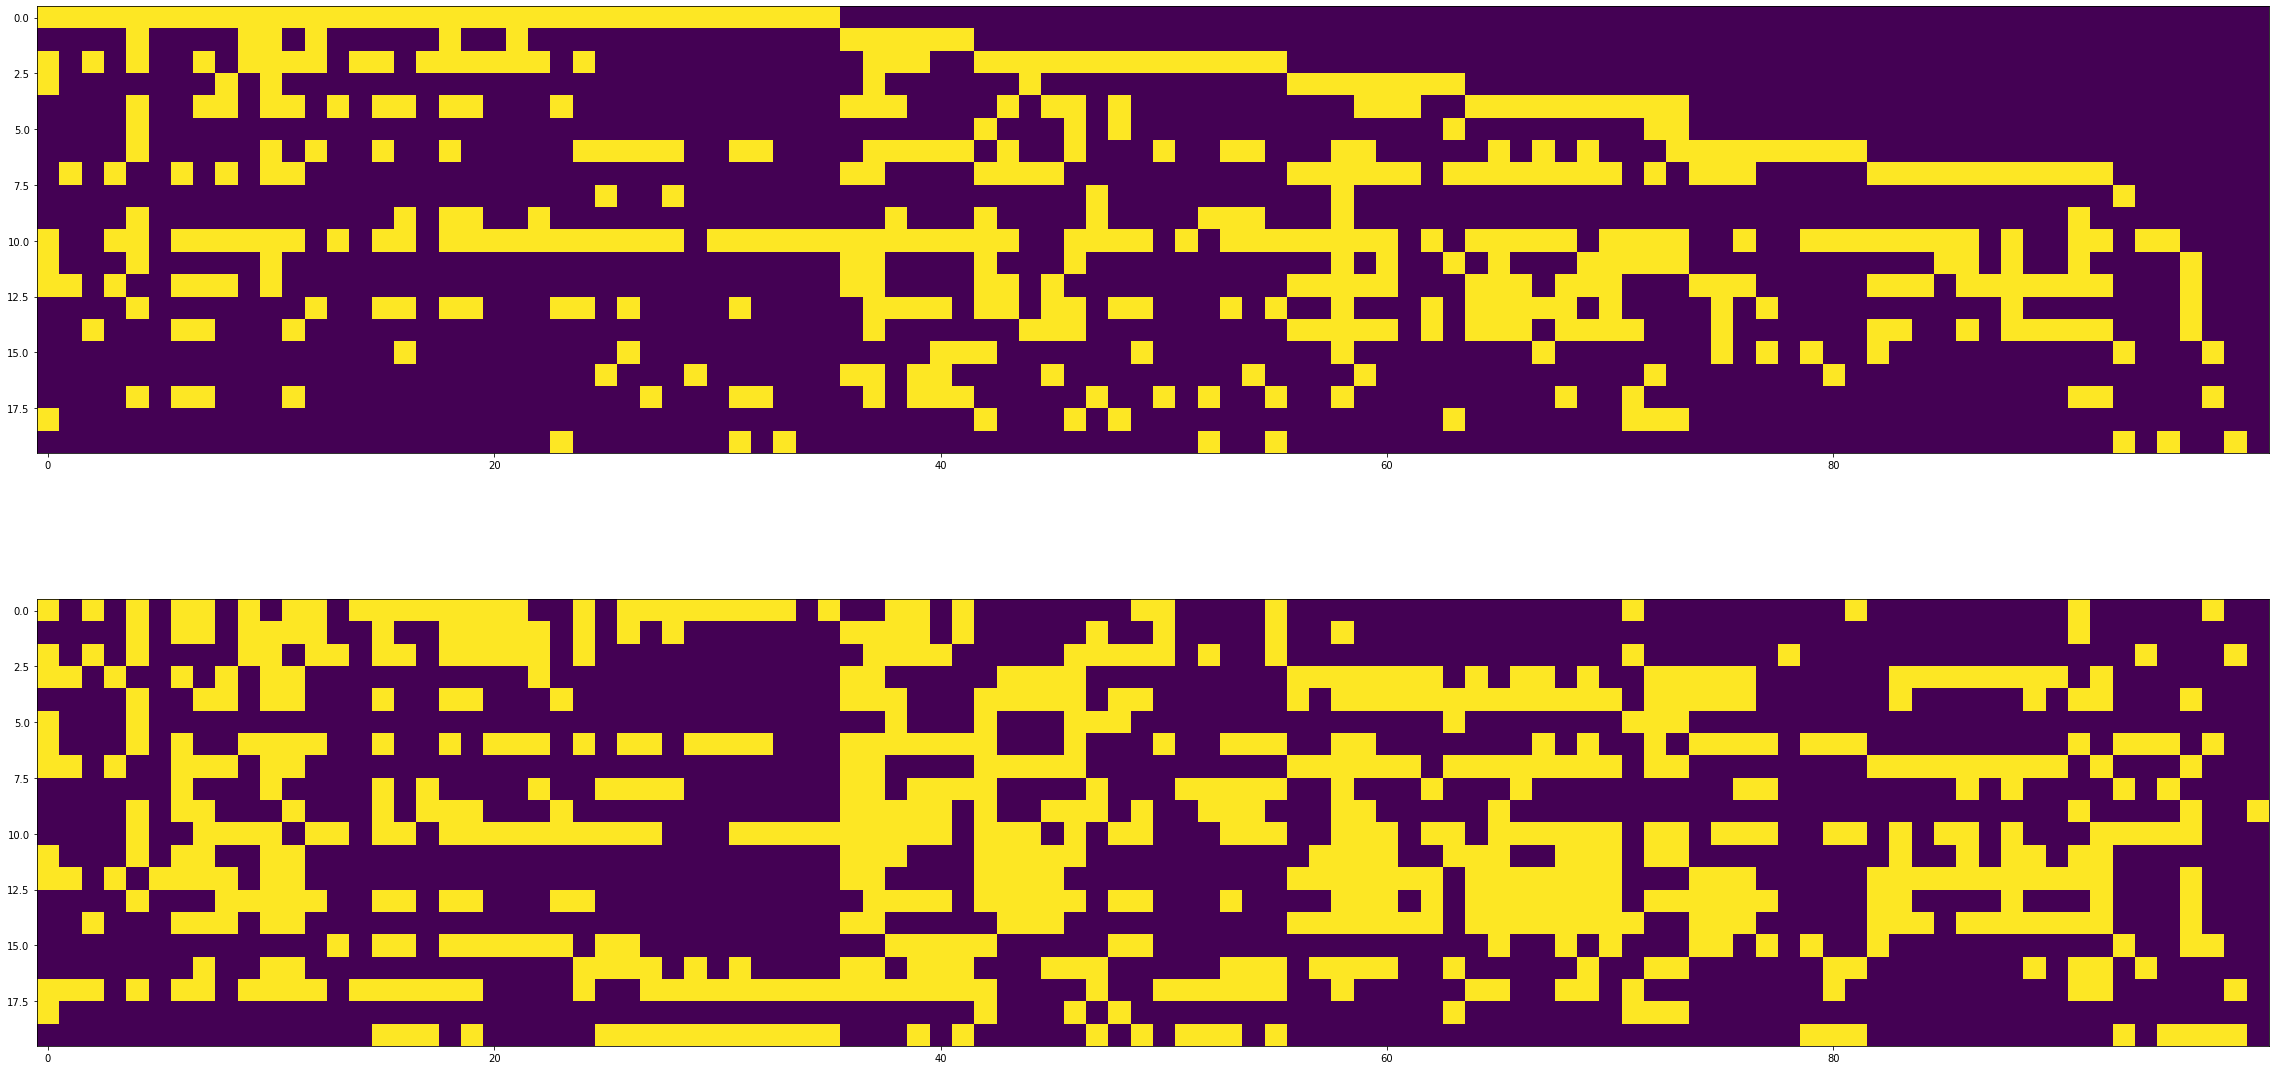

In [14]:
rec_threshold_soft = 0.01
rec_binarized_soft = np.where(rec>=rec_threshold_soft, 1, 0)
_, ax = plt.subplots(2, 1, figsize=(40,subset_size))
ax[0].imshow(data[:subset_size])
ax[1].imshow(rec_binarized_soft)
plt.show()

## Similarities between original and reconstructed data

Graphically speaking, the plots above are informative to have a global view of how the reconstructed data compares with the original data.

It is a good idea, however, to assign a numeric similarity to the comparison. The following functions allow for such comparison

In [15]:
def abs_similarity(a: torch.Tensor, b: np.array):
    # sum of the absolute value difference between two matrices.
    # the closer the value is to zero, the more similar the matrices are
    simil_ = sum(sum(abs(a - b)))
    return simil_

In [16]:
def max_similarity(a: torch.Tensor, b: np.array):
    # maximum of the difference in absolute value of matrices
    # the closer the value is to zero, the more similar the matrices are
    simil_ = ((abs(a - b))).max()
    return simil_

In [17]:
def Frobenius_similarity(a: torch.Tensor, b: np.array):
    # sum of the absolute value squared difference between two matrices
    # (also sum of the singular values of the difference matrix)
    # the closer the value is to zero, the more similar the matrices are
    simil_ = np.linalg.norm(a - b)
    return simil_

#### Similarities for raw reconstructed data

In [18]:
abs_similarity(data[:subset_size], rec)

tensor(489.0396)

In [19]:
max_similarity(data[:subset_size], rec)

tensor(0.9982)

In [20]:
Frobenius_similarity(data[:subset_size], rec)

21.665173

#### Similarities for hard-binarized reconstructed data

In [21]:
abs_similarity(data[:subset_size], rec_binarized_hard)

tensor(487., dtype=torch.float64)

In [22]:
max_similarity(data[:subset_size], rec_binarized_hard)

tensor(1., dtype=torch.float64)

In [23]:
Frobenius_similarity(data[:subset_size], rec_binarized_hard)

22.06807649071391

#### Similarities for soft-binarized reconstructed data

In [24]:
abs_similarity(data[:subset_size], rec_binarized_soft)

tensor(357., dtype=torch.float64)

In [25]:
max_similarity(data[:subset_size], rec_binarized_soft)

tensor(1., dtype=torch.float64)

In [26]:
Frobenius_similarity(data[:subset_size], rec_binarized_soft)

18.894443627691185